In [1]:
import os 
fname = './jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

print('\n'.join(headers))
print(len(lines))

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(headers)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
mean = float_data[:200_000].mean(axis=0)
float_data -= mean
std = float_data[:200_000].std(axis=0)
float_data /= std

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index==None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback , max_index, size=batch_size)
        else :
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i , min(i+batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros(len(rows),)
        
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples,targets

In [5]:
lookback = 720
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, min_index=0, max_index=200_000,shuffle=True, batch_size=batch_size, step=step, delay=delay)
val_gen = generator(float_data, lookback=lookback, min_index=200_001, max_index=300_000, batch_size=batch_size, step=step, delay=delay)
test_gen = generator(float_data, lookback=lookback, min_index=300_001, max_index=None, batch_size=batch_size, step=step, delay=delay)

val_steps = 300_000 - 200_001 - lookback
test_steps = len(float_data) - 300_001 - lookback

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data = val_gen, validation_steps=val_steps//100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

dict_keys(['val_loss', 'loss'])


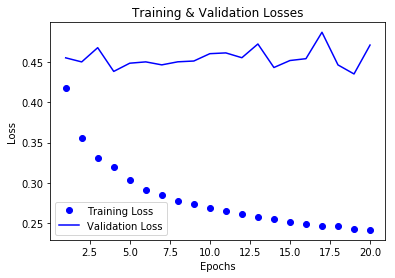

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['loss'])+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [14]:
lookback = 720
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, min_index=0, max_index=200_000,shuffle=True, batch_size=batch_size, step=step, delay=delay)
val_gen = generator(float_data, lookback=lookback, min_index=200_001, max_index=300_000, batch_size=batch_size, step=step, delay=delay)
test_gen = generator(float_data, lookback=lookback, min_index=300_001, max_index=None, batch_size=batch_size, step=step, delay=delay)

val_steps = (300_000 - 200_001 - lookback)//128
test_steps = (len(float_data) - 300_001 - lookback)//128

In [15]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data = val_gen, validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 89s 179ms/step - loss: 0.3373 - val_loss: 0.2910
Epoch 2/20
500/500 [===============

dict_keys(['val_loss', 'loss'])


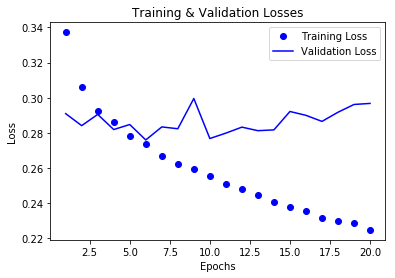

In [16]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['loss'])+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()